In [16]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import pylab
import imageio
from glob import glob
from tqdm import tqdm
from joblib import Parallel, delayed
from videoio import videosave, videoread

In [32]:
KK = glob('results_of_MR/*npy')
#KK = glob('results_of_MR/*3610*npy')

In [33]:
approach = 3

In [34]:
magnitude_vect = -1*np.ones((6500,1))
magnitude_vect = -1*np.ones((6500,1))
for kk in tqdm(KK):
    
    flow = np.load(kk)
    
    # Computes the magnitude and angle of the 2D vectors
    magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1])
    
    if approach == 1:
        #approach 1
        magnitude_vect[int(kk.split('np_flow_')[-1].split('.')[0])] = magnitude.sum()
    elif approach == 2:
        #approach 2
        magnitude_vect[int(kk.split('np_flow_')[-1].split('.')[0])] = (magnitude>10).sum()
    elif approach == 3:
        magnitude_vect[int(kk.split('np_flow_')[-1].split('.')[0])] = (magnitude>10).sum()
        angles = angle * 360 / (np.pi * 2)
        temp1 = angles*(magnitude>5)
        temp1_flat = temp1.flatten()
        temp1_flat2 = temp1_flat[temp1_flat>0]
        [bincount, edges] = np.histogram(temp1_flat2,36)
        if len(bincount[bincount>1000]) > 25:
            magnitude_vect[int(kk.split('np_flow_')[-1].split('.')[0])] = 1e8
        
        
    '''
    # Sets image hue according to the optical flow 
    # direction
    angles = angle * 180 / np.pi / 2

    # Sets image value according to the optical flow
    # magnitude (normalized)
    mag = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)
    '''

100%|██████████| 5550/5550 [00:45<00:00, 121.97it/s]


In [35]:
#magnitude.max(), (magnitude>5).sum(), angle.min(), angle.max(), angles.min(), angles.max(), len(bincount[bincount>1000]), magnitude_vect[int(kk.split('np_flow_')[-1].split('.')[0])]

In [36]:
magnitude_vect_processed = magnitude_vect[magnitude_vect>-1]
frame_idx_processed = np.expand_dims(np.arange(6500),1)
frame_idx_processed = frame_idx_processed[magnitude_vect>-1]

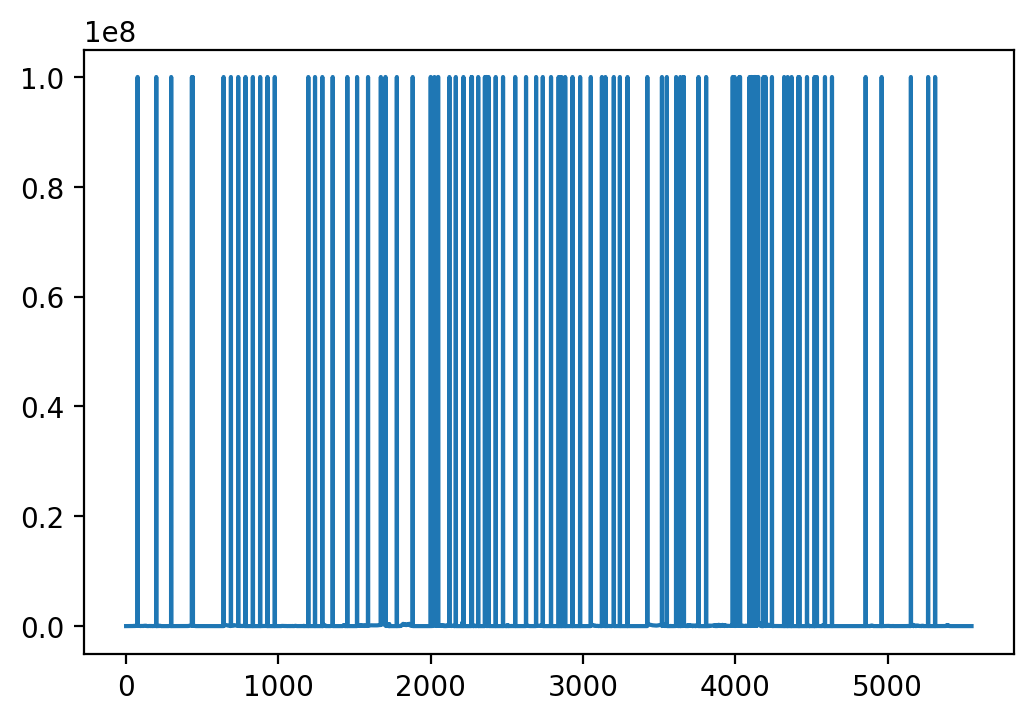

In [37]:
plt.plot(frame_idx_processed,magnitude_vect_processed)

In [38]:
frame_idx_processed2 = frame_idx_processed[np.isfinite(magnitude_vect_processed)]
magnitude_vect_processed2 = magnitude_vect_processed[np.isfinite(magnitude_vect_processed)]

if approach == 1:
    #approach 1
    thold = 5.0e6
elif approach == 2:
    #approach 2
    thold = 1.0e4
elif approach == 3:
    #approach 3
    thold = 5.0e6
    
frame_idx_processed3 = frame_idx_processed2[magnitude_vect_processed2>thold]
magnitude_vect_processed3 = magnitude_vect_processed2[magnitude_vect_processed2>thold]

frame_idx_processed3

array([  76,   77,  199,  297,  433,  436,  439,  641,  689,  737,  785,
        833,  881,  929,  977, 1197, 1241, 1289, 1357, 1453, 1517, 1589,
       1673, 1703, 1704, 1778, 1882, 2000, 2001, 2025, 2048, 2049, 2050,
       2123, 2165, 2215, 2268, 2271, 2312, 2356, 2365, 2366, 2380, 2427,
       2475, 2555, 2626, 2692, 2736, 2790, 2840, 2848, 2859, 2883, 2931,
       2981, 3051, 3124, 3147, 3202, 3242, 3292, 3422, 3518, 3550, 3611,
       3639, 3660, 3662, 3758, 3808, 3982, 3983, 3995, 4026, 4028, 4029,
       4030, 4031, 4093, 4104, 4105, 4109, 4111, 4117, 4127, 4128, 4129,
       4130, 4144, 4149, 4150, 4185, 4198, 4240, 4320, 4343, 4369, 4413,
       4420, 4470, 4520, 4535, 4588, 4634, 4855, 4960, 5152, 5265, 5311])

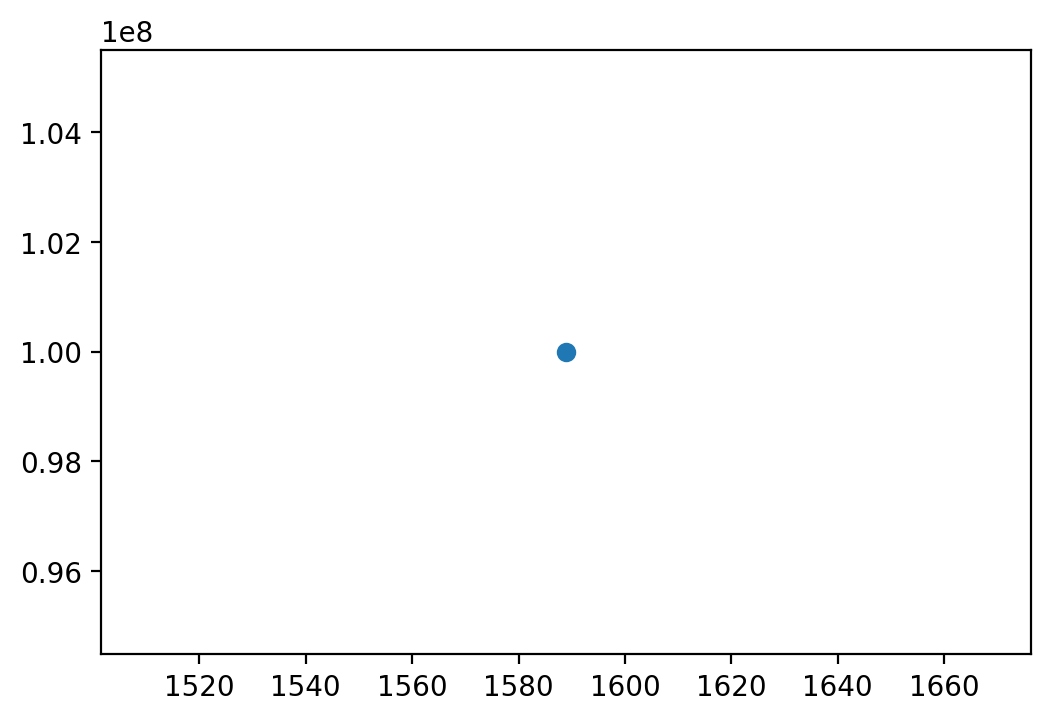

In [39]:
frame_idx_processed4 = frame_idx_processed3[frame_idx_processed3<1650]
magnitude_vect_processed4 = magnitude_vect_processed3[frame_idx_processed3<1650]

frame_idx_processed5 = frame_idx_processed4[frame_idx_processed4>1520]
magnitude_vect_processed5 = magnitude_vect_processed4[frame_idx_processed4>1520]

plt.scatter(frame_idx_processed5,magnitude_vect_processed5)

In [40]:
KK1 = glob('results_of_MR/frame_t_*')
for kk in KK1:
    os.remove(kk)

In [41]:
for idx in tqdm(frame_idx_processed3):
    kk = 'results_of_MR/np_flow_'+str(idx)+'.npy'
    transition_frame = cv2.imread(kk.replace('np_flow','frame').replace('.npy','.png'))
    transition_frame[:,:,2] = 0
    #transition_frame[:,:,0] = 255
    #transition_frame[:,:,1] = 255
    cv2.imwrite(kk.replace('np_flow','frame').replace('.npy','.png').replace('frame','frame_t'),transition_frame)

100%|██████████| 110/110 [00:03<00:00, 35.04it/s]


In [42]:

filename = "9210f99e-da25-41ed-9930-433a24105445_preview.mp4"

first_frame = 0
end_frame = first_frame+5500

vid = imageio.get_reader(filename,  'ffmpeg')
ref_img = vid.get_data(first_frame)

if not os.path.exists('results_of_MR'):
    os.mkdir('results_of_MR')
    
first_frame, end_frame

(0, 5500)

In [43]:

INTERVAL = 400
num_chunks = int(np.ceil((end_frame-first_frame)/INTERVAL))
print(num_chunks)

14


In [44]:
for chunk in range(num_chunks):
    
    first_frame_chunk = first_frame+chunk*INTERVAL
    end_frame_chunk = first_frame+(chunk+1)*INTERVAL
    if end_frame_chunk > end_frame:
        end_frame_chunk = end_frame

    #opt_flow = np.zeros((end_frame_chunk-first_frame_chunk,ref_img.shape[0],ref_img.shape[1],ref_img.shape[2]),np.uint8)
    video_np = np.zeros((end_frame_chunk-first_frame_chunk,ref_img.shape[0],ref_img.shape[1],ref_img.shape[2]),np.uint8)

    kk10 = 0 
    for frame in tqdm(range(first_frame_chunk+1,end_frame_chunk+1)):
        if os.path.exists('results_of_MR/frame_t_'+str(frame)+'.png'):
            img_cv = cv2.imread('results_of_MR/frame_t_'+str(frame)+'.png')
        else:
            img_cv = cv2.imread('results_of_MR/frame_'+str(frame)+'.png')
        #opt_cv = cv2.imread('results_of_MR/optical_flow_'+str(frame)+'.png')

        #opt_flow[kk10,:,:,:] = opt_cv
        video_np[kk10,:,:,:] = img_cv
        kk10+=1
    
    #videosave("out4_"+str(chunk)+".mp4", opt_flow/255)
    videosave("vid_t"+str(approach)+'_'+str(chunk)+".mp4", video_np/255)

100%|██████████| 300/300 [00:03<00:00, 84.27it/s] 


In [ ]:
'''
for chunk in range(num_chunks):
    
    first_frame_chunk = first_frame+chunk*INTERVAL
    end_frame_chunk = first_frame+(chunk+1)*INTERVAL
    if end_frame_chunk > end_frame:
        end_frame_chunk = end_frame

    #opt_flow = np.zeros((end_frame_chunk-first_frame_chunk,ref_img.shape[0],ref_img.shape[1],ref_img.shape[2]),np.uint8)
    video_np = np.zeros((end_frame_chunk-first_frame_chunk,ref_img.shape[0],ref_img.shape[1],ref_img.shape[2]),np.uint8)

    kk10 = 0 
    for frame in tqdm(range(first_frame_chunk+1,end_frame_chunk+1)):
        if os.path.exists('results_of_MR/frame_t_'+str(frame)+'.png'):
            img_cv = cv2.imread('results_of_MR/frame_'+str(frame)+'.png')
        else:
            img_cv = cv2.imread('results_of_MR/frame_'+str(frame)+'.png')
        #opt_cv = cv2.imread('results_of_MR/optical_flow_'+str(frame)+'.png')

        #opt_flow[kk10,:,:,:] = opt_cv
        video_np[kk10,:,:,:] = img_cv
        kk10+=1
    
    #videosave("out4_"+str(chunk)+".mp4", opt_flow/255)
    videosave("vid_clean_"+str(chunk)+".mp4", video_np/255)
'''

In [45]:
from moviepy.editor import *
import os
from natsort import natsorted

L =[]

for i in range(14):

    files = 'vid_t3_4_'+str(i)+'.mp4'
    video = VideoFileClip(files)
    L.append(video)


final_clip = concatenate_videoclips(L)


t:   0%|          | 18/5280 [00:00<00:29, 175.63it/s, now=None]

Moviepy - Building video output.mp4.
Moviepy - Writing video output.mp4



Moviepy - Done !
Moviepy - video ready output.mp4


In [63]:
final_clip